<a href="https://colab.research.google.com/github/fergarcat/pill-data_cleaning_with_python/blob/main/pill_data_cleaning_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Cleaning with Python**

##📚 Creación del origen de datos

A continuación crearemos un dataset "sucio", con la ayuda de las libreríás ***faker*** y ***random***.

El siguiente código contendrá los siguientes errores que tendremos que detectar:
- Ids duplicados
- Nombres nulos (2%)
- Valores atípicos
- Ciudades nulas, cantidad aleatoria.
- Fechas nulas (5%)
- Categoría nula
- Normalización de cadenas de texto
- Conversión de fechas

El resultado se guardará en un csv "dataset_sucio.csv"


###Importar Librerías

In [48]:
%%capture
!pip install faker
import pandas as pd
import numpy as np
from faker import Faker
import random
import seaborn as sns
import matplotlib.pyplot as plt

###Generación del Dataset

In [49]:
# Inicializar Faker para generar datos aleatorios
fake = Faker("es_ES")

# Configuración de aleatoriedad para reproducibilidad
np.random.seed(42)
random.seed(42)

# Número de registros
num_registros = 500

def ajustar_longitud(lista, longitud):
    """Asegura que la lista tenga la longitud correcta, rellenando o truncando si es necesario."""
    while len(lista) < longitud:
        lista.append(None)
    return lista[:longitud]

# Crear listas de datos con errores comunes
ids = list(range(1, num_registros + 1)) + [random.randint(1, num_registros // 2) for _ in range(10)]  # IDs duplicados
ids = ajustar_longitud(ids, num_registros + 10)

nombres = [fake.first_name() if random.random() > 0.02 else np.nan for _ in range(num_registros + 10)]  # 2% NaN en nombres
edades = [random.choice(range(15, 85)) if random.random() > 0.02 else random.choice([-5, 150]) for _ in range(num_registros + 10)]  # Valores atípicos (-5, 150)
ciudades = [fake.city() if random.random() > 0.02 else np.nan for _ in range(num_registros + 10)]  # Algunas ciudades nulas

# Salarios con formatos inconsistentes y valores erróneos
salarios = [random.choice([
    "€" + str(random.randint(20000, 80000)),
    str(random.randint(20000, 80000)),
    "NaN",  # Valor mal escrito
    "-10000",  # Salario negativo (erróneo)
    str(random.randint(20000, 80000)) + " Euros",  # Salario con palabra "Euros"
]) for _ in range(num_registros + 10)]

# Fechas con formatos distintos y celdas vacías
fechas_registro = [
    fake.date_between(start_date="-3y", end_date="today") if random.random() > 0.05 else random.choice([
        "10-03-2023", "2023/05/21", "No registrada", None
    ]) for _ in range(num_registros + 10)]

# Columna categórica con valores nulos e inconsistencias
categorias = [random.choice(["A", "B", "C", "D", "a", "b", None, "Sin dato"]) for _ in range(num_registros + 10)]

# Generar fechas con errores
fechas = [
    random.choice([
        f"2024-{str(random.randint(1, 12)).zfill(2)}-01",
        f"01/{random.randint(1, 12)}/2024",
        f"2024/{random.randint(1, 12)}/01",
        "Fecha incorrecta",
        None
    ]) for _ in range(num_registros + 10)]

# Crear DataFrame
df = pd.DataFrame({
    "ID": ids,
    "Nombre": nombres,
    "Edad": edades,
    "Ciudad": ciudades,
    "Salario": salarios,
    "Fecha_Registro": fechas_registro,
    "Categoría": categorias,
    "Fecha": fechas
})

# Guardar como CSV
df.to_csv("dataset_sucio.csv", index=False)

# Mostrar primeras filas
filtered_df = df[df['Salario'].str.contains("Euros")]
print(filtered_df.head())



    ID      Nombre  Edad     Ciudad      Salario Fecha_Registro Categoría  \
0    1    Trinidad    47   Albacete  57845 Euros     2023-04-05         a   
4    5       Julia    23    Melilla  23994 Euros     2024-02-06         A   
6    7  Emperatriz    46    Vizcaya  47997 Euros     2023/05/21         B   
17  18     Mariana    63  Cantabria  26059 Euros     2023-03-27         C   
19  20      Pelayo    46  Castellón  64149 Euros     2024-11-27         D   

               Fecha  
0   Fecha incorrecta  
4         01/11/2024  
6   Fecha incorrecta  
17  Fecha incorrecta  
19        2024-05-01  


##💾 Transformar el CSV a DataFrame

In [50]:
# Cargar dataset
df = pd.read_csv("dataset_sucio.csv")

##♦ Detección y tratamiento de errores

A continuación comprobaremos y trataremos las siguientes incoherencias de datos:

- Duplicados en la columna ID.

- Maneja valores nulos, rellenando con datos adecuados.

- Limpia la columna Salario, eliminando valores negativos y reemplazando NaN con la mediana.

- Filtra edades inválidas (<18 o >100).

- Normaliza nombres (primera letra en mayúscula).

- Estandariza las categorías (SIN DATO → SIN CATEGORÍA).


El dataset limpio se guardará en ***dataset_limpio.csv***

###1. Valores nulos (Missing Values)

####1.1 Detección de valores nulos
Podemos usar un gráfico de calor para ver las celdas con valores nulos.

Valores nulos por columna:
ID                  0
Nombre             11
Edad                0
Ciudad              5
Salario           102
Fecha_Registro      3
Categoría          64
Fecha             107
dtype: int64


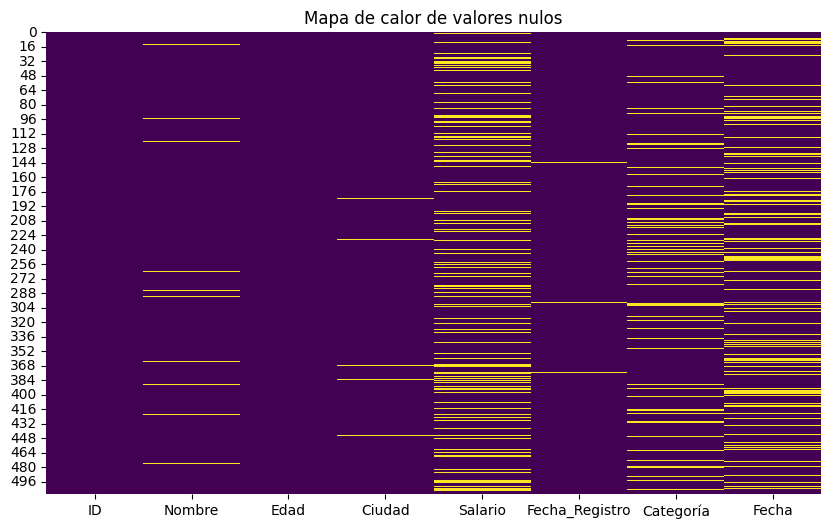

In [51]:
# Imprimir la cantidad de valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

# Mapa de calor de los valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de calor de valores nulos")
plt.show()

####1.2 Tratamiento de valores nulos

In [52]:
# Manejar valores nulos
df["Nombre"].fillna("Desconocido", inplace=True)
df["Ciudad"].fillna(df["Ciudad"].mode()[0], inplace=True)  # Reemplazar por la ciudad más común
df["Fecha_Registro"] = pd.to_datetime(df["Fecha_Registro"], errors="coerce")  # Convertir a formato de fecha
df["Categoría"].fillna("Sin Categoría", inplace=True)  # Rellenar valores vacíos en Categoría

<ipython-input-52-d84d48cc197c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Nombre"].fillna("Desconocido", inplace=True)
<ipython-input-52-d84d48cc197c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

###2. Duplicados

####2.1 Detección de duplicados
  Podemos graficar la cantidad de filas duplicadas para tener una idea de cuántas ocurrencias repetidas hay.

Total de duplicados en 'ID': 10


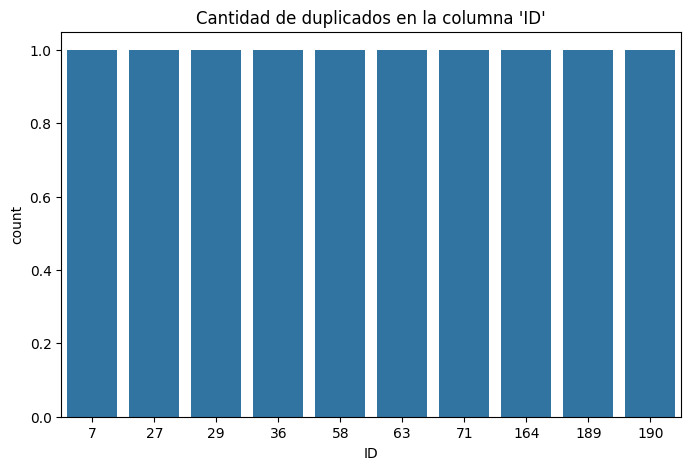

In [53]:
# Verificar duplicados
duplicados = df[df.duplicated(subset='ID')]

# Imprimir el número de duplicados en la columna 'ID'
print(f"Total de duplicados en 'ID': {duplicados.shape[0]}")

# Gráfico de barras de duplicados
plt.figure(figsize=(8, 5))
sns.countplot(x=duplicados['ID'])
plt.title("Cantidad de duplicados en la columna 'ID'")
plt.show()

####2.2 Eliminar duplicados

In [54]:
# 2. Eliminar duplicados en la columna ID
df = df.drop_duplicates(subset="ID")

###3. Valores atípicos (Outliers)

####3.1 Detección de valores atípicos
Usaremos un gráfico de caja para identificar los valores atípicos, por ejemplo, en la columna Edad y Salario.

Estadísticas de la columna 'Edad':
count    500.000000
mean      50.442000
std       21.426826
min       -5.000000
25%       32.750000
50%       52.000000
75%       68.000000
max      150.000000
Name: Edad, dtype: float64
Estadísticas de la columna 'Salario':
count        402
unique       298
top       -10000
freq         105
Name: Salario, dtype: object


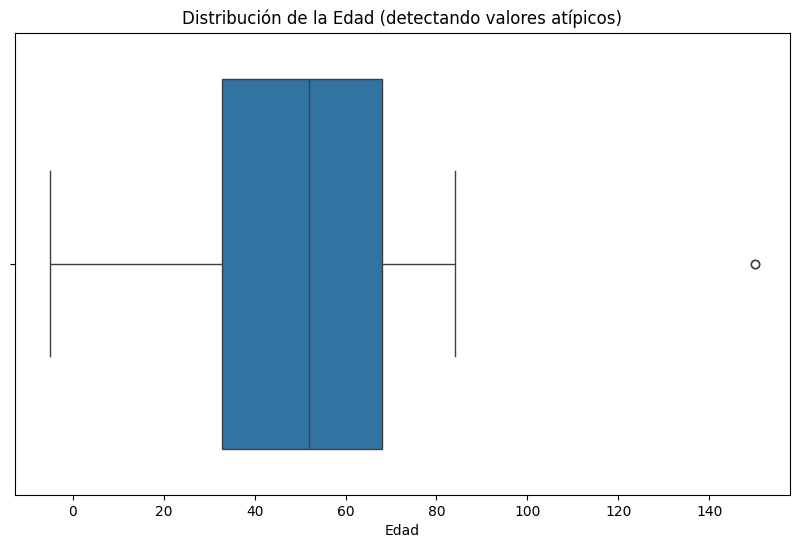

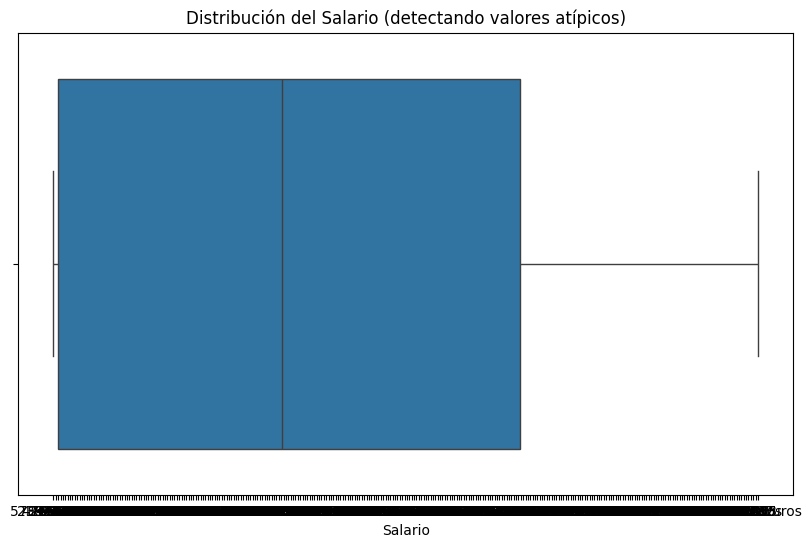

In [55]:
# Imprimir estadísticas de la columna 'Edad' para ver valores atípicos
print("Estadísticas de la columna 'Edad':")
print(df['Edad'].describe())

# Imprimir estadísticas de la columna 'Salario' para ver valores atípicos
print("Estadísticas de la columna 'Salario':")
print(df['Salario'].describe())

# Detección de valores atípicos en Edad
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Edad'])
plt.title("Distribución de la Edad (detectando valores atípicos)")
plt.show()

# Detección de valores atípicos en Salario
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Salario'])
plt.title("Distribución del Salario (detectando valores atípicos)")
plt.show()

####3.2 Tratamiento de valores atípicos

In [56]:
# Limpiar la columna Salario
df["Salario"] = df["Salario"].astype(str) \
    .str.replace("€", "", regex=False) \
    .str.replace("Euros", "", regex=False) \
    .str.replace("NaN", "0", regex=False) \
    .str.strip()  # Eliminar espacios en blanco

# Convertir a número (forzando errores a NaN)
df["Salario"] = pd.to_numeric(df["Salario"], errors="coerce")

# Eliminar valores negativos
df.loc[df["Salario"] < 0, "Salario"] = np.nan

# Reemplazar NaN con la mediana
df["Salario"] = df["Salario"].fillna(df["Salario"].median())

# Filtrar edades inválidas
df = df[(df["Edad"].between(18, 100))]  # Más eficiente que usar `&`


###4. Fechas incorrectas

####4.1   Detección de incocherencias en fechas
Podemos ver si las fechas están en un formato inconsistente utilizando un gráfico de barras con el conteo de fechas inválidas (por ejemplo, las fechas en texto).

<ipython-input-57-e50bfb58caf6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fecha_Registro'] = pd.to_datetime(df['Fecha_Registro'], errors='coerce')


Total de fechas inválidas: 25


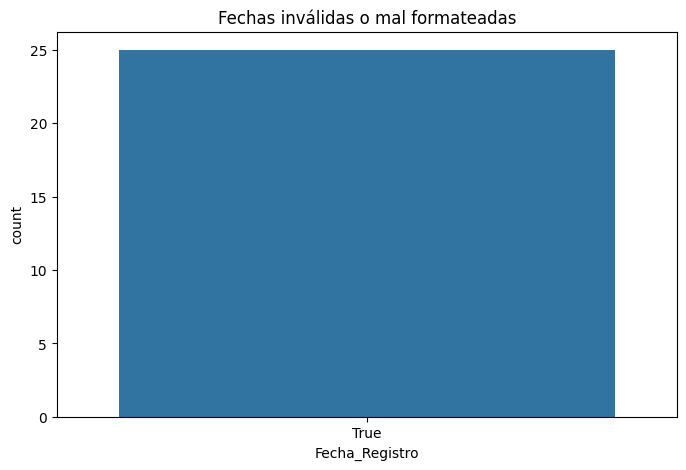

Fechas con formato incorrecto:


In [57]:
# Verificar formato de fecha
df['Fecha_Registro'] = pd.to_datetime(df['Fecha_Registro'], errors='coerce')
fechas_invalidas = df[df['Fecha_Registro'].isnull()]

# Imprimir la cantidad de fechas inválidas
print(f"Total de fechas inválidas: {fechas_invalidas.shape[0]}")

# Conteo de fechas inválidas
plt.figure(figsize=(8, 5))
sns.countplot(x=fechas_invalidas['Fecha_Registro'].isnull())
plt.title("Fechas inválidas o mal formateadas")
plt.show()
# Imprimir los valores incorrectos
print("Fechas con formato incorrecto:")

# COMPROBACIÓN NO NECESARIA A PRIORI. TO_DATETIME ES CAPAZ DE INTERPRETAR TANTO dd-mm-yyyy como yyyy-mm-dd
# # Función para detectar fechas incorrectas
# def detectar_formato_fecha(fecha):
#     try:
#         # Intentar convertir con el formato correcto
#         pd.to_datetime(fecha, format="%d-%m-%Y")
#         return "Correcta"
#     except ValueError:
#         return "Formato Incorrecto"

# # Aplicar la detección a la columna 'Fecha_Registro'
# df["Formato_Fecha"] = df["Fecha_Registro"].astype(str).apply(detectar_formato_fecha)

# # Filtrar solo las fechas incorrectas
# fechas_incorrectas = df[df["Formato_Fecha"] == "Formato Incorrecto"]
# print(fechas_incorrectas[["ID", "Fecha_Registro"]])


# # Graficar la cantidad de fechas con errores
# plt.figure(figsize=(6, 4))
# sns.countplot(y=fechas_incorrectas["Formato_Fecha"], palette="coolwarm")
# plt.title("Cantidad de fechas con formato incorrecto")
# plt.xlabel("Cantidad")
# plt.ylabel("Formato de Fecha")
# plt.show()




####4.2 Corregir fechas

In [58]:
#Corregir la columna Fecha
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")  # Convertir fechas incorrectas a NaT
df["Fecha"].fillna(pd.to_datetime("2024-01-01"), inplace=True)  # Rellenar NaT con un valor por defecto

<ipython-input-58-032f24fe5f05>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")  # Convertir fechas incorrectas a NaT
<ipython-input-58-032f24fe5f05>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Fecha"].fillna(pd.to_datetime("2024-01-01"), inplace=True)  # Rellenar NaT con un valor por defecto


###5. Detección de valores erróneos en el salario

####5.1 Errores en salarios
Para encontrar valores erróneos como saldos negativos, podemos usar un gráfico de barras.

Valores de salario con formato incorrecto:
      ID  Salario
0      1  57845.0
1      2  48925.0
3      4  48925.0
4      5  23994.0
5      6  77652.0
..   ...      ...
495  496  48925.0
496  497  48925.0
497  498  48925.0
498  499  48925.0
499  500  54120.0

[478 rows x 2 columns]

Salarios negativos detectados:
Empty DataFrame
Columns: [ID, Salario]
Index: []


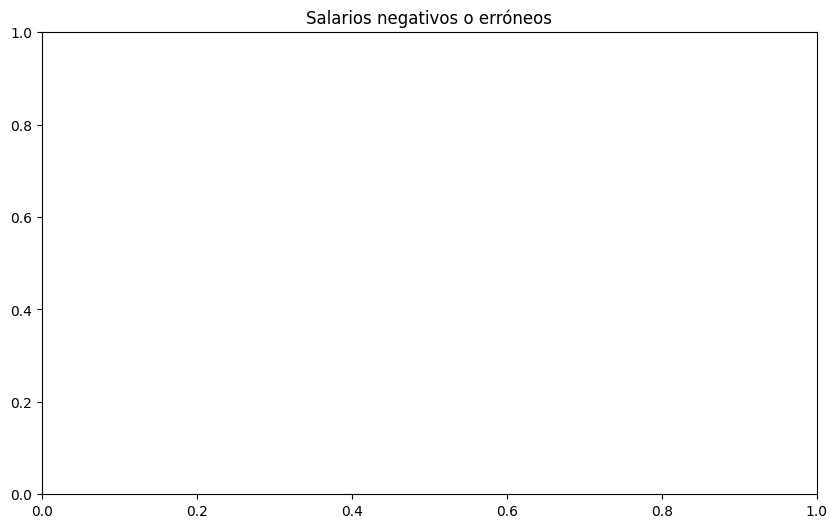

In [59]:
# Detectar valores no numéricos en la columna Salario
errores_tipo = df[~df["Salario"].astype(str).str.replace("€", "").str.replace("Euros", "").str.replace("NaN", "").str.isnumeric()]

# Detectar salarios negativos (evitando errores por valores no numéricos)
salarios_erroneos = df[df["Salario"].astype(str).str.startswith("-")]

# Imprimir los valores no numéricos y negativos detectados
print("Valores de salario con formato incorrecto:")
print(errores_tipo[["ID", "Salario"]])

print("\nSalarios negativos detectados:")
print(salarios_erroneos[["ID", "Salario"]])

# Graficar los salarios negativos
plt.figure(figsize=(10, 6))
sns.countplot(x=salarios_erroneos["Salario"])
plt.title("Salarios negativos o erróneos")
plt.show()


####5.2 Limpiar la columna de salario

In [60]:
# 3. Limpiar la columna Salario
df["Salario"] = df["Salario"].astype(str).str.replace("€", "").str.replace("NaN", "0").str.replace(" Euros", "").astype(float)
df["Salario"] = df["Salario"].apply(lambda x: x if x > 0 else np.nan)  # Eliminar valores negativos
df["Salario"].fillna(df["Salario"].median(), inplace=True)  # Reemplazar NaN con la mediana

<ipython-input-60-5a100bc7a4c8>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Salario"].fillna(df["Salario"].median(), inplace=True)  # Reemplazar NaN con la mediana


###6. Detección de valores nulos o vacíos en columnas categóricas

####6.1 Detección de valores nulos o vacíos
Finalmente, podemos graficar la cantidad de celdas vacías por cada columna para tener una visión general de la falta de datos.

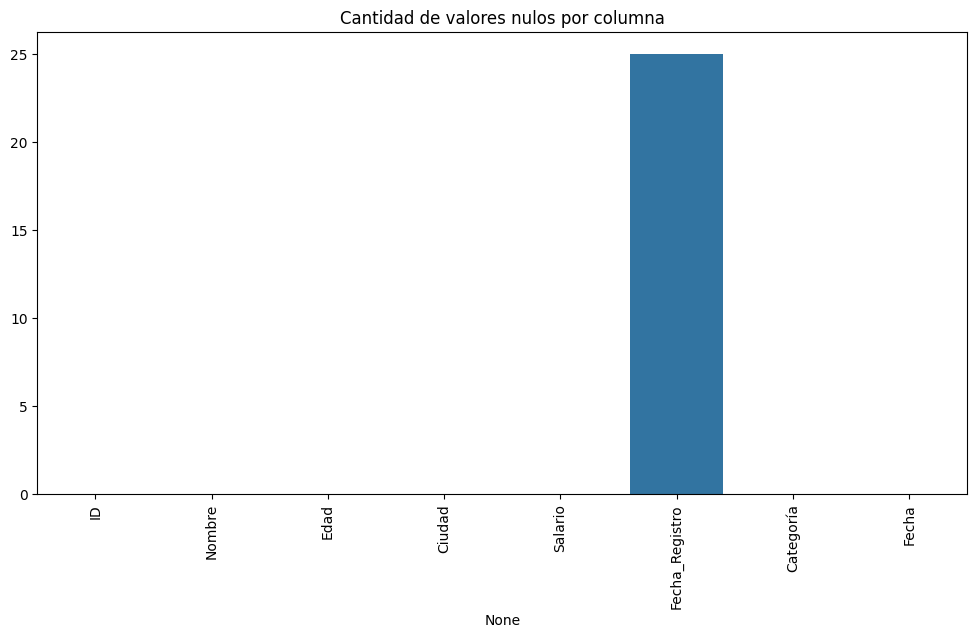

In [61]:
# Contar valores nulos en cada columna
null_counts = df.isnull().sum()

# Gráfico de barras para nulos
plt.figure(figsize=(12, 6))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.title("Cantidad de valores nulos por columna")
plt.xticks(rotation=90)
plt.show()

####6.2 Tratamiento de valores nulos o vacíos

In [62]:
#Normalizar nombres (primera letra en mayúscula)
df["Nombre"] = df["Nombre"].str.title()

#Normalizar categorías
df["Categoría"] = df["Categoría"].str.upper()
df["Categoría"].replace("SIN DATO", "SIN CATEGORÍA", inplace=True)


<ipython-input-62-7cb0f881c326>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Categoría"].replace("SIN DATO", "SIN CATEGORÍA", inplace=True)


##💎 Exportamos el DataFrame limpio a un CSV

In [63]:
# Guardar el dataset limpio
df.to_csv("dataset_limpio.csv", index=False)

# Mostrar datos limpios
print(df.head())

   ID    Nombre  Edad      Ciudad  Salario Fecha_Registro Categoría      Fecha
0   1  Trinidad    47    Albacete  57845.0     2023-04-05         A 2024-01-01
1   2     Nerea    75      Murcia  48925.0     2024-03-23         C 2024-02-01
3   4  Demetrio    59     Almería  48925.0     2024-07-07         B 2024-04-01
4   5     Julia    23     Melilla  23994.0     2024-02-06         A 2024-01-11
5   6   Luciana    20  Valladolid  77652.0     2022-10-26         C 2024-09-01
